In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Dataset

El dataset escogido [data-science-bowl-2018-dataset](https://www.kaggle.com/encoded/data-science-bowl-2018-dataset) ha sido extraido de la competición [2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018) la cual tenia como objetivo la segmentación de núcleos celulares. 

La identificación de núcleos celulares es el punto de partida para la mayoría de análisis puesto que el cuerpo humano contiene más de 30 billones de células con ADN. La identificación de los núcleos celulares en una muestra permite a los investigadores  medir cómo reaccionan las células a diversos tratamientos.


<div style="text-align: center;"> 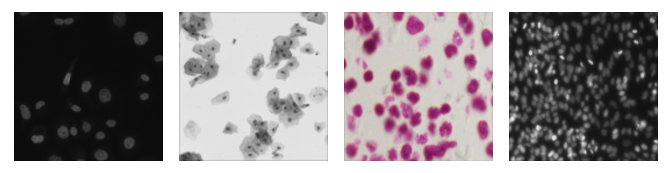 </div>



In [1]:
#Importación de librerias
from tensorflow.keras.utils import normalize
import os
import cv2 as cv
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob
import random


In [2]:
SIZE= 128 #Tamaño de la imagen
n_classes=1 #Binario
directory_path = '../input/data-science-bowl-2018-dataset/'

In [3]:
def read_files(folder):
    image_names = glob.glob(directory_path+folder+"/img/*.png")
    image_names.sort()
    images = [cv.imread(img) for img in image_names]
    images = np.array(images)
    
    mask_names = glob.glob(directory_path+folder+"/labelcol/*.png")
    mask_names.sort()
    #La máscara no es completamente binaria, por lo que se va a realizar una binarización
    mask_binary=[]
    for mask in mask_names:
        m = cv.imread(mask, 0)
        ret,thresh1 = cv.threshold(m,200,255,cv.THRESH_BINARY)
        mask_binary.append(thresh1)
    masks = np.array(mask_binary)
    masks = np.expand_dims(masks, axis = 3)
    
    #Normalización, escalamos de (0 a 255 -> 0 a 1)
    images = images /255
    masks = masks /255
    return images,masks

In [4]:
X_train,y_train=read_files("train folder")
X_test,y_test=read_files("test folder")
X_val,y_val=read_files("validation folder")

In [5]:
#Comprobación de que el dataset es correcto
print("Imagenes de entrenamiento: ", X_train.shape)
print("Mascaras: ", y_train.shape)
print("Maximo valor del pixel de la imagen: ", X_train.max())
print("Etiquetas en la mascara: ", np.unique(y_train))

print("Imagenes de test: ", X_test.shape)
print("Imagenes de validación: ", X_val.shape)

Imagenes de entrenamiento:  (520, 128, 128, 3)
Mascaras:  (520, 128, 128, 1)
Maximo valor del pixel de la imagen:  1.0
Etiquetas en la mascara:  [0. 1.]
Imagenes de test:  (76, 128, 128, 3)
Imagenes de validación:  (75, 128, 128, 3)


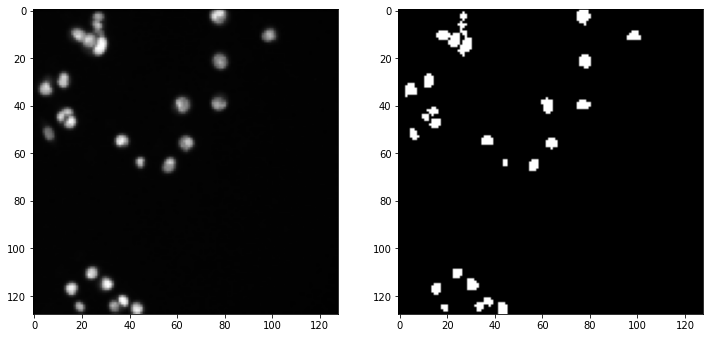

In [6]:
#Comprobación de que el dataset es correcto
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

# UNet

Para realizar la segmentación se va a utilizar el modelo UNet. Esta arquitectura fue introducida en el artículo
[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) y su nombre se debe a su forma de U. En este modelo, la entrada de la red es la imagen a segmentar y la salida es su mapa de segmentación.

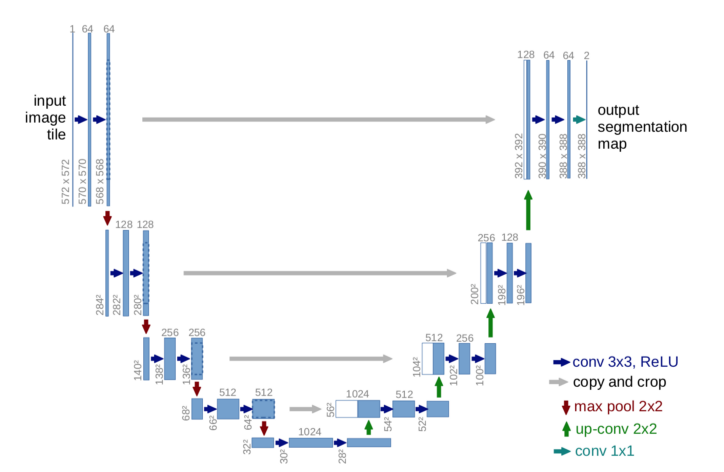.

Tal como se muestra en la imagen, la red tiene una parte descendente y otra ascendente. La primera de ellas consta de capas de convolución combinadas con otras de disminución de resolución (downsampling), y se encarga de extraer la significación semántica. La segunda fase(ascendente), se encarga de construir el mapa de segmentación semántica y se compone de capas de convolución e incremento de resolución (upsampling).

Las conexiones intermedias o "skip connections" permiten pasar información de la capa descendente a la ascendente para la construcción del mapa de segmentación.

A continuación se va a implementar esta arquitectura mediante bloques, de tal forma que se pueda adaptar a otros proyectos.

- **Bloque convolucional:** está formado por dos capas convolucionales con el mismo número de filtros 3x3.
- **Bloque encoder:** está formado por 2 capas convolucionales (bloque convolucional) seguido de downsampling (maxpooling 2x2).
- **Bloque decoder:** upsampling (traspuesta), concatenación y bloque convolucional



In [7]:
# Construcción de Unet mediante bloques
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

#Bloque convolucional
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Bloque encoder: Bloque convolucional + maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Bloque decoder: upsampling + concatenación
#"skip features" o conexiones intermedias proviene del bloque encoder
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Construcción de Unet usando los bloques
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Puente

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binario
        activation = 'sigmoid'
    else:            #Multiples clases    
        activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #La función de activación cambia según el número de clases
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [8]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Métricas para evaluar un modelo de Segmentación

Las métricas más utilizadas en segmentación son **IoU** y **Dice Coefficient**. 

La métrica accuracy no sería adecuada ya que en un modelo de segmentación intenta clasificar correctamente que píxel pertenece a cada clase. Usualmente una gran cantidad de píxeles pertenecen al fondo y no al objeto segmentado, por lo que se produce el problema de desbalanceo de clases.

### Intersection-Over-Union (IoU, Jaccard Index)

Iou es el área que se solapa entre la segmentación predicha y la real, dividida entre la unión entre la segmentación predicha y la real. Esta metrica tiene un rango 0-1 (0-100%), donde 0 significa que no existe solapamiento y 1 significa un perfecto solapamiento entre la segmentación predicha y la real.

<div style="width:100%;text-align: center;"> 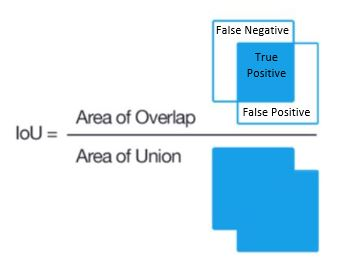 </div>

### Dice Coefficient (F1 Score)

Dice Coefficient es 2 veces el área solapada entre la segmentación predicha y la real dividido por el número total de píxeles.

<div style="width:100%;text-align: center;"> 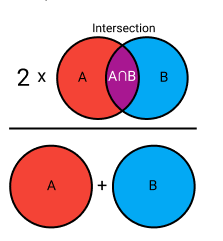 </div>

Dice Coefficient y IoU son muy similares y están positivamente correlacionadas. 
En este proyecto se va a utilizar IoU.

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return (1 - dice_coef(y_true, y_pred))

In [23]:
def IoU_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)


def IoU_coef_loss(y_true, y_pred):
    return (1-IoU_coef(y_true, y_pred))  


In [24]:
import tensorflow
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping

model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=IoU_coef_loss, metrics=[IoU_coef])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128, 128, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 128, 128, 64) 0           batch_normalization_18[0][0]     
______________________________________________________________________________________

In [25]:
es = EarlyStopping(monitor='IoU_coef', mode='max', verbose=1, patience=10, restore_best_weights=True)

In [27]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=200, 
                    validation_data=(X_val, y_val), callbacks = [es],
                    shuffle=False)

Epoch 1/200
33/33 [==============================] - 4s 126ms/step - loss: 0.3111 - IoU_coef: 0.6891 - val_loss: 0.8144 - val_IoU_coef: 0.1855
Epoch 2/200
33/33 [==============================] - 4s 120ms/step - loss: 0.3034 - IoU_coef: 0.6968 - val_loss: 0.5908 - val_IoU_coef: 0.4126
Epoch 3/200
33/33 [==============================] - 4s 120ms/step - loss: 0.2917 - IoU_coef: 0.7084 - val_loss: 0.4903 - val_IoU_coef: 0.5091
Epoch 4/200
33/33 [==============================] - 4s 121ms/step - loss: 0.2830 - IoU_coef: 0.7172 - val_loss: 0.6058 - val_IoU_coef: 0.3882
Epoch 5/200
33/33 [==============================] - 4s 120ms/step - loss: 0.2870 - IoU_coef: 0.7131 - val_loss: 0.4007 - val_IoU_coef: 0.5956
Epoch 6/200
33/33 [==============================] - 4s 127ms/step - loss: 0.2669 - IoU_coef: 0.7333 - val_loss: 0.3779 - val_IoU_coef: 0.6184
Epoch 7/200
33/33 [==============================] - 4s 121ms/step - loss: 0.2545 - IoU_coef: 0.7458 - val_loss: 0.3683 - val_IoU_coef: 0.6284

In [28]:
#Guardar modelo
model.save('./model5.hdf5')

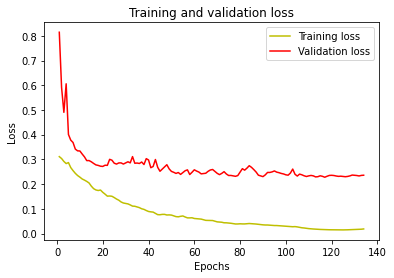

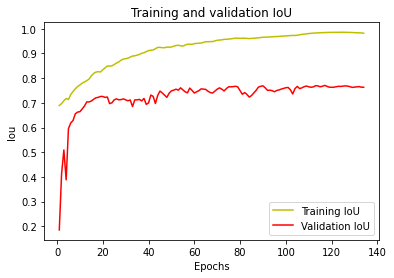

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['IoU_coef']
val_acc = history.history['val_IoU_coef']
plt.plot(epochs, acc, 'y', label='Training IoU ')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('Iou')
plt.legend()
plt.show()

# Evaluación de los resultados

In [31]:
#Importamos el modelo
from keras.models import load_model
model = load_model("./model5.hdf5", compile=False)
        

(1, 128, 128, 3)
(128, 128)


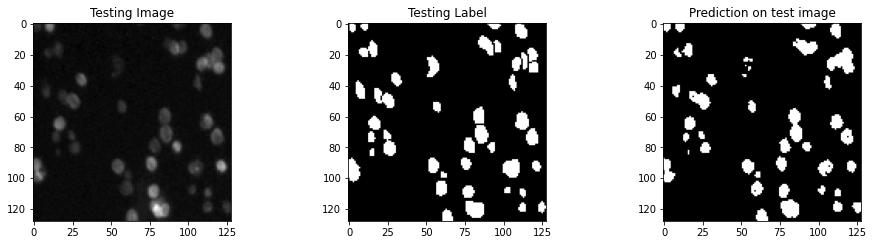

In [32]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [33]:
#IOU
#Estamos utilizando sigmoid, es decir, obtenemos una probabilidad entre 0 y 1
#Si se supera el umbral 0.5, es un núcleo celular
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

In [34]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2 # binario 0 o 1
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8813227


El resultado obtenido es de 0.88. Este valor es bastante bueno y podemos observar en las imagenes anteriores que se consigue segmentar con éxito los núcleos celulares aunque le falta un poco de precisión.